In [1]:
#import needed libraries (although not all imported below are used in the given code)

import os
from os import listdir
from os.path import isfile, join

import sys
import codecs
import fileinput
import string
from collections import OrderedDict

import numpy as np

from pandas import DataFrame
import pandas as pd

import matplotlib

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

#from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import optimize, stats
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths,hilbert

from decimal import Decimal



import iminuit 


import csv
import cmath
import math
from math import sqrt




# destination to the data (input) and output folders (change according to the path on your PC)

containing_folder_path = "/home/mfedkevych/Work/LZ/"
path_base = containing_folder_path + "code_backup/Analysis/AmBe-2_noW_remote_with_attenuator/"
measurement_path= path_base +'Data/'
measurement_output_path= path_base + 'Results/'

#calibration parameters
p0_cal=0.974
p1_cal=1.1

#function to count number of significant digits after comma
def number_sigdigs(x):
    digs_after_comma = str(x - math.floor(x))
    digs_after_comma = digs_after_comma[2:]
    number=0
    for c in digs_after_comma:
        if c=='0':
            number+=1
        else:
            number+=2
            break
    return number

print('numpy version', np.__version__)
print('matplotlib version', matplotlib.__version__)
print('pandas version', pd.__version__)
print('scipy version', scipy.__version__)
print('iminuit version', iminuit.__version__)

numpy version 1.25.1
matplotlib version 3.7.2
pandas version 2.0.3
scipy version 1.11.1
iminuit version 2.22.0


In [2]:
# read the data files from measurement_path folder and replace "," delimiter without "."

files_in_folder = [f for f in listdir (measurement_path) if isfile(join(measurement_path, f))]
files_in_folder.sort()

for f in files_in_folder:
    
    name = 0

    # Read in the file
    with open(measurement_path+f, 'r') as input_file :
        filedata = input_file.read()

         # Replace the target string
        filedata = filedata.replace(",", ".")

    # Write the file out again
    with open(measurement_path+f, 'w') as input_file:
        input_file.write(filedata)
    input_file.close()

In [3]:
# read the data files and put the content into list of dataframes

numbers=np.linspace(0,8191,num=8192)
numbers=list(numbers)

import re

scan = [] #list of scan data (in DataFrame format) extracted from measurement files
files_scan=[] #list of scan files

for f in files_in_folder:
    if "AmBe" in f: #choose only files without names containing "AmBE"
        
        print(f) #prints scan file name
        files_scan.append(f)
        


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1), # skip the points (rows) where the magnetic field did not stabilize yet
            header=None,
            delimiter="\t",
            #skip_blank_lines=True,
            )
        #scan_temp.insert(1, 1, numbers, True)
        print(scan_temp) #prints scan file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

for f in files_in_folder:
    if "Background" in f: #choose only files without names containing "Background"
        
        print(f) #prints measurement file name
        files_scan.append(f) 
        


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

#combine background data
background=scan[1][1]



AmBe-2_remote_position_no_capsule.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
20221108_Background.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]


In [4]:
#checking that the measurement files have been read and written in the right order

i=0
while i<len(files_scan):
    print(i, files_scan[i])
    i+=1


0 AmBe-2_remote_position_no_capsule.dat
1 20221108_Background.dat


In [5]:
#give background measurement time and AmBe-2 measurement time
t_bkg=64517.94
t=21594


8192


/tmp/ipykernel_8972/769683791.py:94: RuntimeWarning: invalid value encountered in sqrt
  discrepancy = (measured_spectrum[:-1]  - rebin_simulated_counts) / np.sqrt(measured_spectrum[:-1] + rebin_simulated_counts)
/tmp/ipykernel_8972/769683791.py:94: RuntimeWarning: invalid value encountered in divide
  discrepancy = (measured_spectrum[:-1]  - rebin_simulated_counts) / np.sqrt(measured_spectrum[:-1] + rebin_simulated_counts)


<Figure size 1700x1400 with 0 Axes>

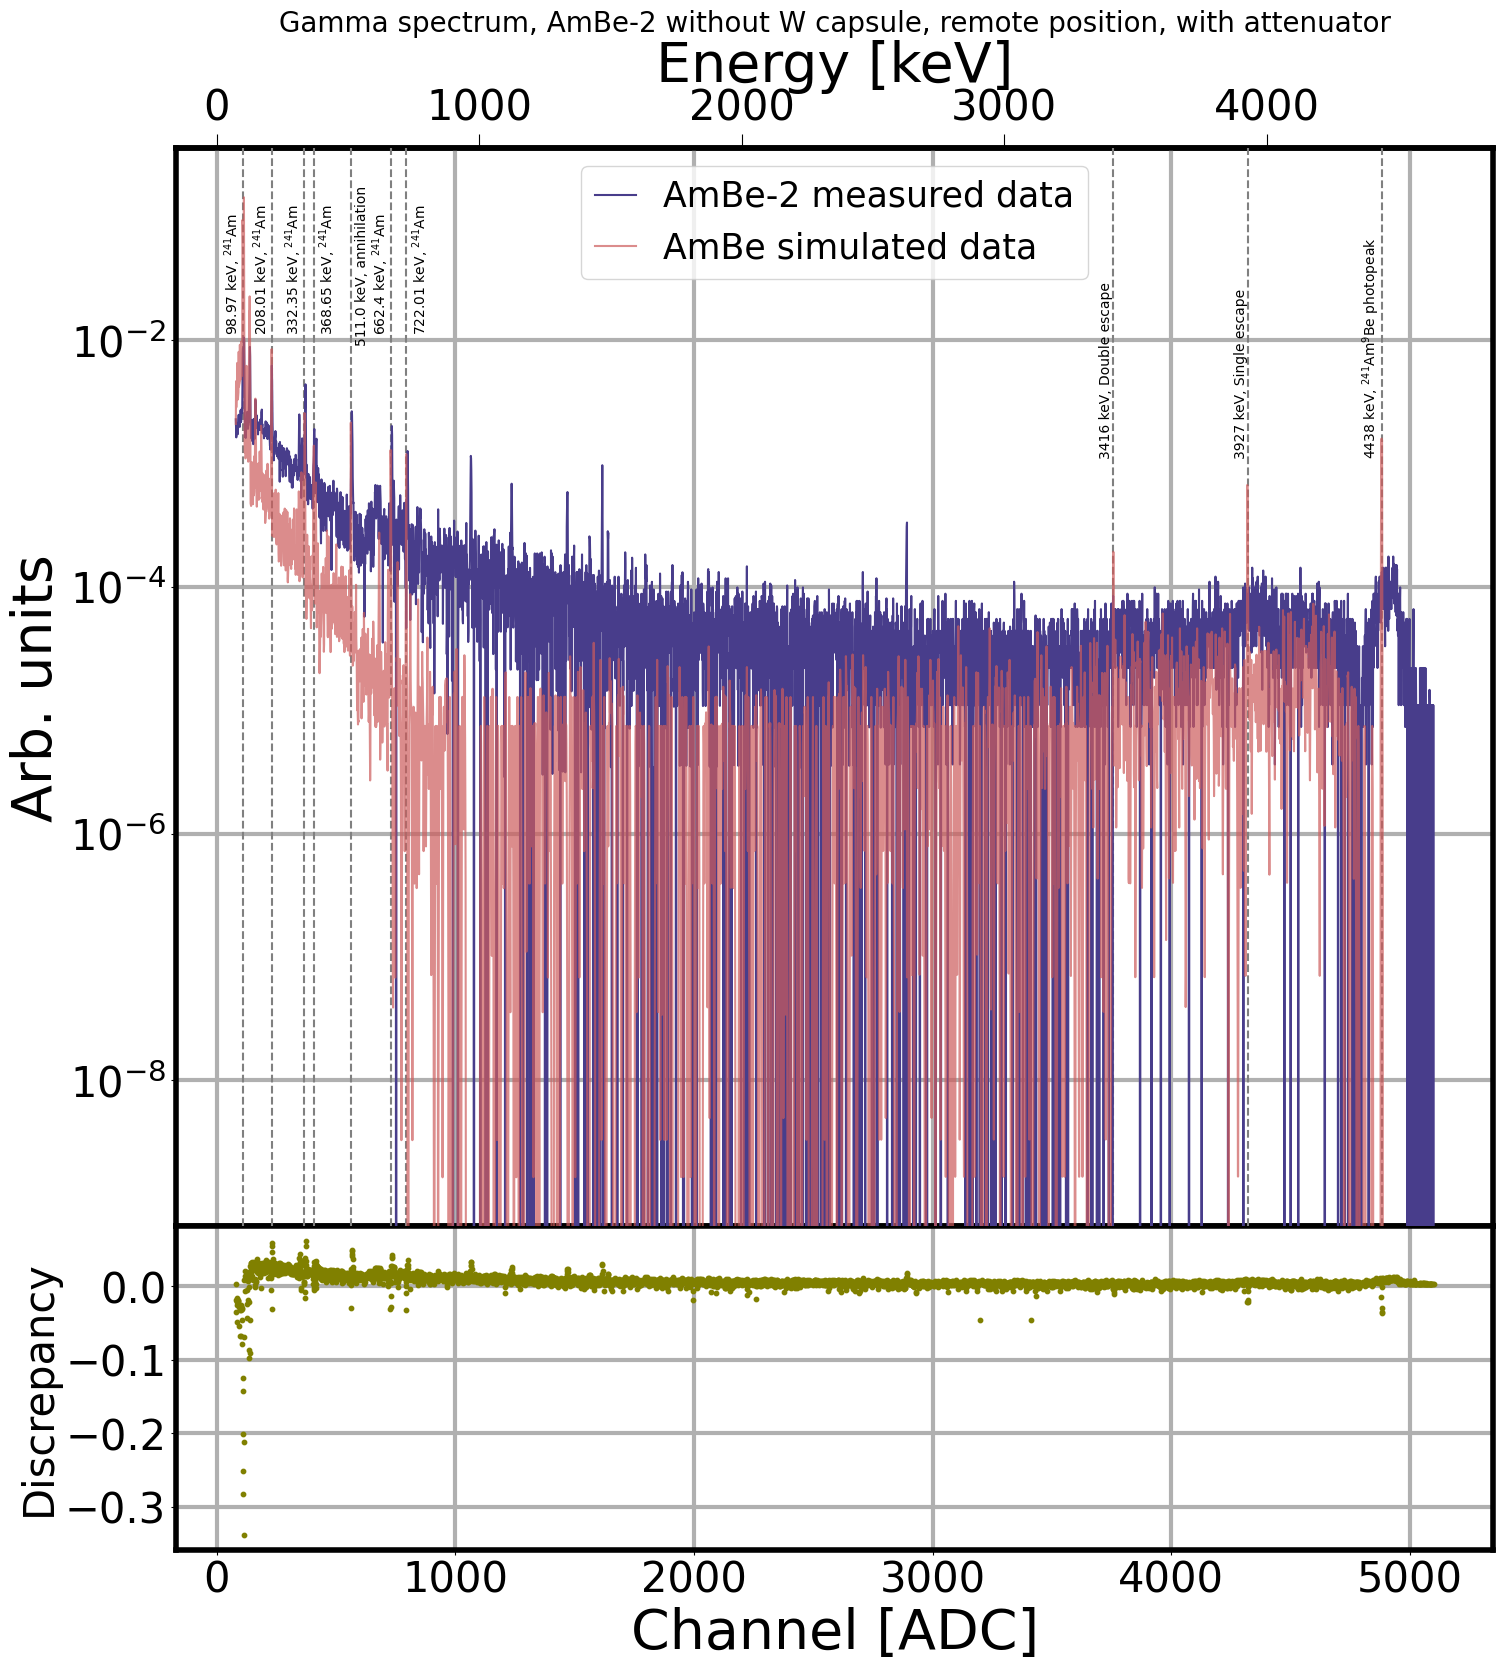

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#define variables for the order of plotting
analysis_extra_kwargs = {"zorder": 200}
analysis_kwargs = {"zorder": 100}
level_kwargs = {"zorder": 80}
data_kwargs = {"zorder": 50}
error_kwargs = {"zorder": 25}
grid_kwargs = {"zorder": 0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65

# Load the arrays from the file
loaded_data = np.load("simulated_spectrum_data.npz")
simulated_spectrum_energies = loaded_data["energies"]
simulated_spectrum_counts = loaded_data["counts"]

# Calibrate ADC channels to energy in keV
simulated_energy_ADC = simulated_spectrum_energies * 1000 * p1_cal + p0_cal

# Use the measured gamma spectrum
print(len(np.asarray(scan[0][0])))
measured_energy_ADC = np.asarray(scan[0][0])[:simulated_energy_ADC.size]
measured_spectrum = (np.asarray(scan[0][1]) / t - np.asarray(background) / t_bkg)[:simulated_energy_ADC.size]

# Apply the cut on both simulated and measured data
cut_low = 80
cut_high = 5100
mask = (measured_energy_ADC >= cut_low) & (measured_energy_ADC <= cut_high)
measured_energy_ADC = measured_energy_ADC[mask]
measured_spectrum = measured_spectrum[mask]

mask = (simulated_energy_ADC >= cut_low) & (simulated_energy_ADC <= cut_high)
simulated_energy_ADC = simulated_energy_ADC[mask]
simulated_spectrum_counts = simulated_spectrum_counts[mask]

# Step 4: Plot the true spectrum
plt.figure()
fig, ax1 = plt.subplots()
# Define function and its inverse
f = lambda x: (x - p0_cal) / p1_cal
g = lambda x: p1_cal * x + p0_cal

ax2 = ax1.secondary_xaxis("top", functions=(f, g))
ax2.tick_params(direction='out', axis='x', length=10)

# Calibrate ADC channels to energy in keV
measured_energy_keV = (measured_energy_ADC - p0_cal) / p1_cal

# Use numpy.histogram to rebin the simulated data
rebin_simulated_counts, _ = np.histogram(simulated_energy_ADC, bins=measured_energy_ADC, weights=simulated_spectrum_counts)

ax1.plot(measured_energy_ADC, measured_spectrum / sum(measured_spectrum), color="darkslateblue", label="AmBe-2 measured data", **analysis_extra_kwargs)
# Plot the rebinned simulated data
ax1.plot(measured_energy_ADC[:-1], rebin_simulated_counts / np.sum(rebin_simulated_counts), color="indianred", alpha=0.7, label="AmBe simulated data", **analysis_extra_kwargs)

plt.title('Gamma spectrum, AmBe-2 without W capsule, remote position, with attenuator', fontsize=20)
ax1.set_ylabel(u"Arb. units", fontsize=40)

ax2.set_xlabel("Energy [keV]", fontsize=40)

# Set axes tick parameters


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax2.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)


    
plt.yscale('log')

measured_spectrum /= sum(measured_spectrum)
rebin_simulated_counts /= np.sum(rebin_simulated_counts)

# Calculate the discrepancy between measurement and simulation
discrepancy = (measured_spectrum[:-1]  - rebin_simulated_counts) / np.sqrt(measured_spectrum[:-1] + rebin_simulated_counts)

# Create a new subplot below the existing plot
ax3 = ax1.inset_axes([0, -0.3, 1, 0.3])  # Adjust the third parameter as needed for proper spacing

# Plot the discrepancy data
ax3.scatter(measured_energy_ADC[:-1], discrepancy, color="olive", s=10, label="Discrepancy", **analysis_extra_kwargs)

# Set axes tick parameters for the new subplot
for tl in ax3.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)

for tl in ax3.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax3.set_xlabel("Channel [ADC]", fontsize=40)
ax3.set_ylabel("Discrepancy", fontsize=30)
ax3.grid()  # add grid to the new subplot

# Remove x-axis tick labels from ax1
ax1.set_xticklabels([])


peak_annotations=[98.97,208.01,332.35,368.65,511.0,662.4,722.01,3416,3927,4438]
peak_annotations_additions=['$^\mathrm{241}$Am','$^\mathrm{241}$Am','$^\mathrm{241}$Am','$^\mathrm{241}$Am','annihilation','$^\mathrm{241}$Am','$^\mathrm{241}$Am','Double escape','Single escape','$^\mathrm{241}$Am$^\mathrm{9}$Be photopeak']
position = ['right','right','right','left','left','right','left','right','right','right']
text_offset = [0,0,0,15,15,0,15,0,0,0]
y_position=[1.1e-2,1.1e-2,1.1e-2,1.1e-2,0.9e-2,1.1e-2,1.1e-2,1.1e-3,1.1e-3,1.1e-3]

for peak in peak_annotations:   
    ax1.axvline(x=peak * p1_cal+ p0_cal, ymin=0, ymax=1, color='gray', linestyle='dashed',**data_kwargs)
    ax1.text(peak * p1_cal+ p0_cal+text_offset[peak_annotations.index(peak)], y_position[peak_annotations.index(peak)], '{} keV, {}'.format(peak, peak_annotations_additions[peak_annotations.index(peak)]), rotation=90, va='bottom', ha=position[peak_annotations.index(peak)], fontsize=10, color='black')



plt.grid()  # add grid to the plot
plt.legend(prop={'size': 25})



# Save and show the plot
plt.savefig(measurement_output_path + "Gamma_spectrum_AmBe-2_noW_withAt_ADC-Ch_vs_simulated.png", bbox_inches='tight')
plt.show()
